In [8]:
import numpy as np
from scipy.spatial import ConvexHull
from scipy.stats import variation
import matplotlib.pyplot as plt


In [61]:
def get_distance(p1, p2):
  return np.linalg.norm(p1-p2)

def get_edge_length_dict(pts, hull):
  """
  map (pid1, pid2) to length
  """
  edge_length_dict = {}
  for simplex in hull.simplices:
    for i in range(3):
      pid1 = simplex[i]
      pid2 = simplex[(i+1)%3]
      if pid1>pid2:
        pid1, pid2 = pid2, pid1
    edge_length_dict[(pid1, pid2)] = get_distance(pts[pid1], pts[pid2])
  return edge_length_dict

def get_edge_length_cnt_dict(edge_length_dict: dict, precision_percent=1e-4):
  """
  map edge_length to cnt
  """
  shortest = min(edge_length_dict.values())
  tol = shortest * precision_percent
  precision = -int(np.log10(tol))

  edge_length_cnt_dict = dict()
  for l in edge_length_dict.values():
    l = round(l, precision)
    if l in edge_length_cnt_dict:
      edge_length_cnt_dict[l] += 1
    else:
      edge_length_cnt_dict[l] = 1

  return edge_length_cnt_dict

def get_joint_type_cnt(pts, hull, precision = 3):
  n = hull.npoints
  neighbours_set_list: list[set] = [None]*n
  for i in range(n):
    neighbours_set_list[i] = set()

  ## get neighbours, unordered
  for simplex in hull.simplices:
    a, b, c = simplex
    neighbours_set_list[a].add(b)
    neighbours_set_list[a].add(c)
    neighbours_set_list[b].add(a)
    neighbours_set_list[b].add(c)
    neighbours_set_list[c].add(a)
    neighbours_set_list[c].add(b)

  ## order neighbours
  joints = set()
  for i in range(n):
    l = list(neighbours_set_list[i])
    neighbours_cnt = len(l)

    ## connect in one direction
    sorted_cnt = 1
    while sorted_cnt < neighbours_cnt-1:
      for j in range(sorted_cnt, neighbours_cnt):
        if l[j] in neighbours_set_list[l[sorted_cnt-1]]:
          l[j], l[sorted_cnt] = l[sorted_cnt], l[j]
          sorted_cnt += 1
          break

    ## cnter clockwise
    if np.dot(pts[l[0]], np.cross(pts[l[1]]-pts[l[0]], pts[l[2]]-pts[l[1]])) < 0:
      l.reverse()

    edge_directions = []
    for j in range(neighbours_cnt):
      edge_directions.append(
        pts[l[(j+1)%neighbours_cnt]] - pts[l[j]]
      )
    
    ## angles clockwise
    angles = []
    for j in range(neighbours_cnt):
      dir1 = edge_directions[(j+1)%neighbours_cnt]
      dir2 = edge_directions[j]
      angle = round(
        np.arccos(np.dot(dir1, dir2)/np.linalg.norm(dir1)/np.linalg.norm(dir2)),
        precision,
      )
      angles.append(angle)

    ## sort the angle list
    min_a = min(angles)

    js = []
    for j, a in enumerate(angles):
      if a == min_a:
        js.append(j)

    angles_lists = []
    for j in js:
      angles_lists.append(list(np.roll(angles, -j)))

    angles = sorted(angles_lists)[0]

    joints.add(tuple(angles))

  return len(joints)

In [62]:
def get_stats(ds, basepath):
  pt_cnts = []
  edge_type_cnts = []
  joint_type_cnts = []
  cvs = []
  min_max_ratios = []
  for d in ds:
    pts = np.loadtxt(f"{basepath}/{d}.txt").reshape(-1, 3)
    n = pts.shape[0]
    hull = ConvexHull(pts)
    edge_length_dict = get_edge_length_dict(pts, hull)
    edge_length_cnt = get_edge_length_cnt_dict(edge_length_dict)
    edge_length_type_cnt = len(edge_length_cnt)
    joint_type_cnt = get_joint_type_cnt(pts, hull)
    cv = variation(list(edge_length_dict.values()))
    min_max_ratio = min(edge_length_dict.values())/max(edge_length_dict.values())

    pt_cnts.append(n)
    edge_type_cnts.append(edge_length_type_cnt)
    joint_type_cnts.append(joint_type_cnt)
    cvs.append(cv)
    min_max_ratios.append(min_max_ratio)

  return pt_cnts, edge_type_cnts, joint_type_cnts, cvs, min_max_ratios

In [63]:
stats_ic1s = get_stats(range(1,27), "out/manual/ic1s/txt_dump")
stats_ic1s

([12,
  42,
  92,
  162,
  252,
  362,
  492,
  642,
  812,
  1002,
  1212,
  1442,
  1692,
  1962,
  2252,
  2562,
  2892,
  3242,
  3612,
  4002,
  4412,
  4842,
  5292,
  5762,
  6252,
  6762],
 [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26],
 [1,
  2,
  3,
  4,
  5,
  7,
  8,
  9,
  11,
  12,
  13,
  15,
  16,
  17,
  19,
  20,
  21,
  23,
  24,
  25,
  27,
  28,
  29,
  31,
  32,
  33],
 [4.474410909220539e-14,
  0.06077034231861601,
  0.0567518949188778,
  0.07277545881833423,
  0.07725135114569906,
  0.07775700171347837,
  0.07901244451042855,
  0.07955509439359114,
  0.07992294466470198,
  0.0806265810816489,
  0.08089820224164734,
  0.08141266518426951,
  0.08141826925590191,
  0.08159332911841222,
  0.08129810022324163,
  0.08205684689289298,
  0.0822320230878467,
  0.08203845396600676,
  0.08223437803139862,
  0.08187090238572305,
  0.08207349991683334,
  0.08204494350071974,
 

In [64]:
stats_ic2s = get_stats(range(1,33,2), "out/manual/ic2s/txt_dump")
stats_ic2s

([12,
  32,
  122,
  272,
  482,
  752,
  1082,
  1472,
  1922,
  2432,
  3002,
  3632,
  4322,
  5072,
  5882,
  6752],
 [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30],
 [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30],
 [4.474410909220539e-14,
  0.051060041821055314,
  0.06535321874007435,
  0.07332471049409274,
  0.07487237203544062,
  0.07502851707999149,
  0.07521137129036476,
  0.07577432182864945,
  0.07715652770338205,
  0.07456761013770508,
  0.07703520170583254,
  0.07677913436560109,
  0.07669347170404082,
  0.07620158925219452,
  0.07656642809321923,
  0.07651253561187876],
 [0.9999999999998822,
  0.8979990848905248,
  0.8045923347748383,
  0.779640757010979,
  0.768665720893798,
  0.7625934181295606,
  0.7587649698057126,
  0.756139705182824,
  0.7542310980377164,
  0.7527825989973392,
  0.7516466223689076,
  0.750732282761872,
  0.7499806946948372,
  0.7493522559480664,
  0.7488189597583764,
  0.7483608200182493])

In [65]:
stats_min_potential = get_stats(range(4,300), "out/v1.0.2/min_potential/txt_dump")
stats_min_potential

([4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
  1

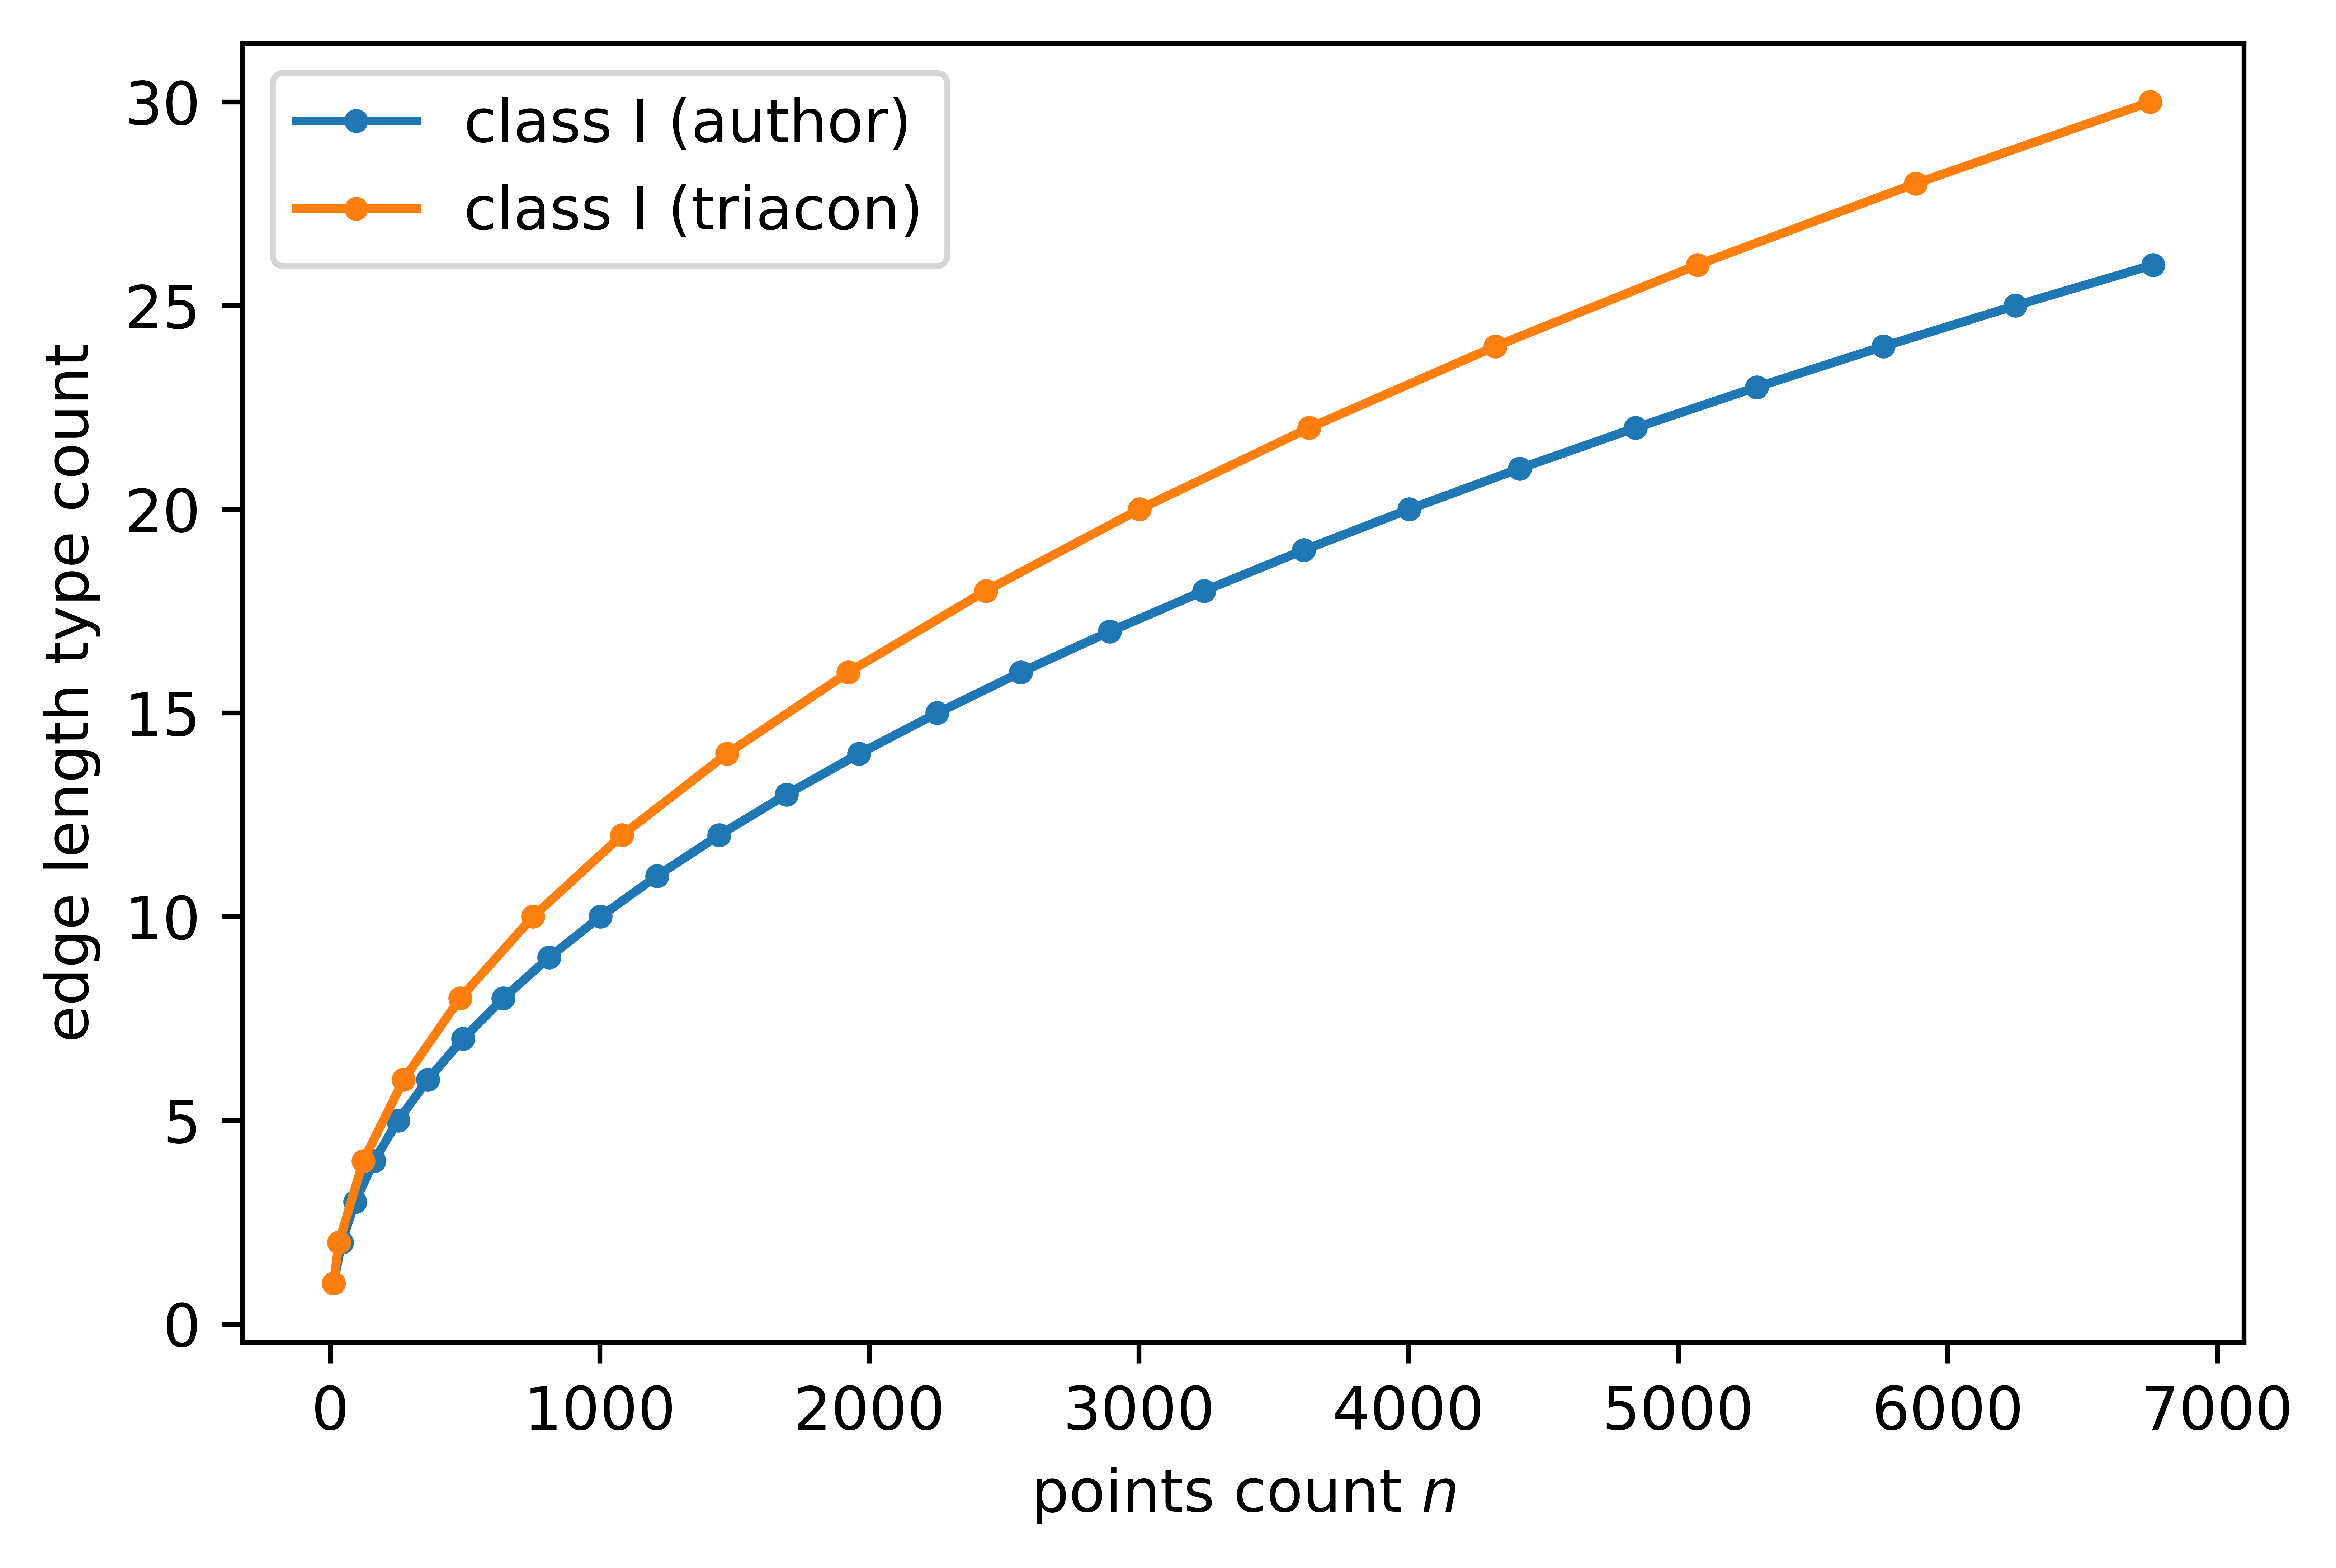

In [69]:
plt.figure(
  # figsize=(10,6),
  dpi=1200,
)
l1 = plt.plot(stats_ic1s[0], stats_ic1s[1], marker='.', label='class I (author)')
l2 = plt.plot(stats_ic2s[0], stats_ic2s[1], marker='.', label='class I (triacon)')
plt.xlabel("points count $n$")
plt.ylabel("edge length type count")
plt.legend()

plt.savefig("out/share/image/edge_length_type_compare.jpg")

# ns = stats_ic2s[0]

# stats_min_potential_selected_x = []
# stats_min_potential_selected_y = []
# for i, n in enumerate(stats_min_potential[0]):
#   if n in ns and n in range(4,300):
#     stats_min_potential_selected_x.append(stats_min_potential[0][i])
#     stats_min_potential_selected_y.append(stats_min_potential[1][i])


# plt.plot(stats_min_potential_selected_x, stats_min_potential_selected_y, marker='.')

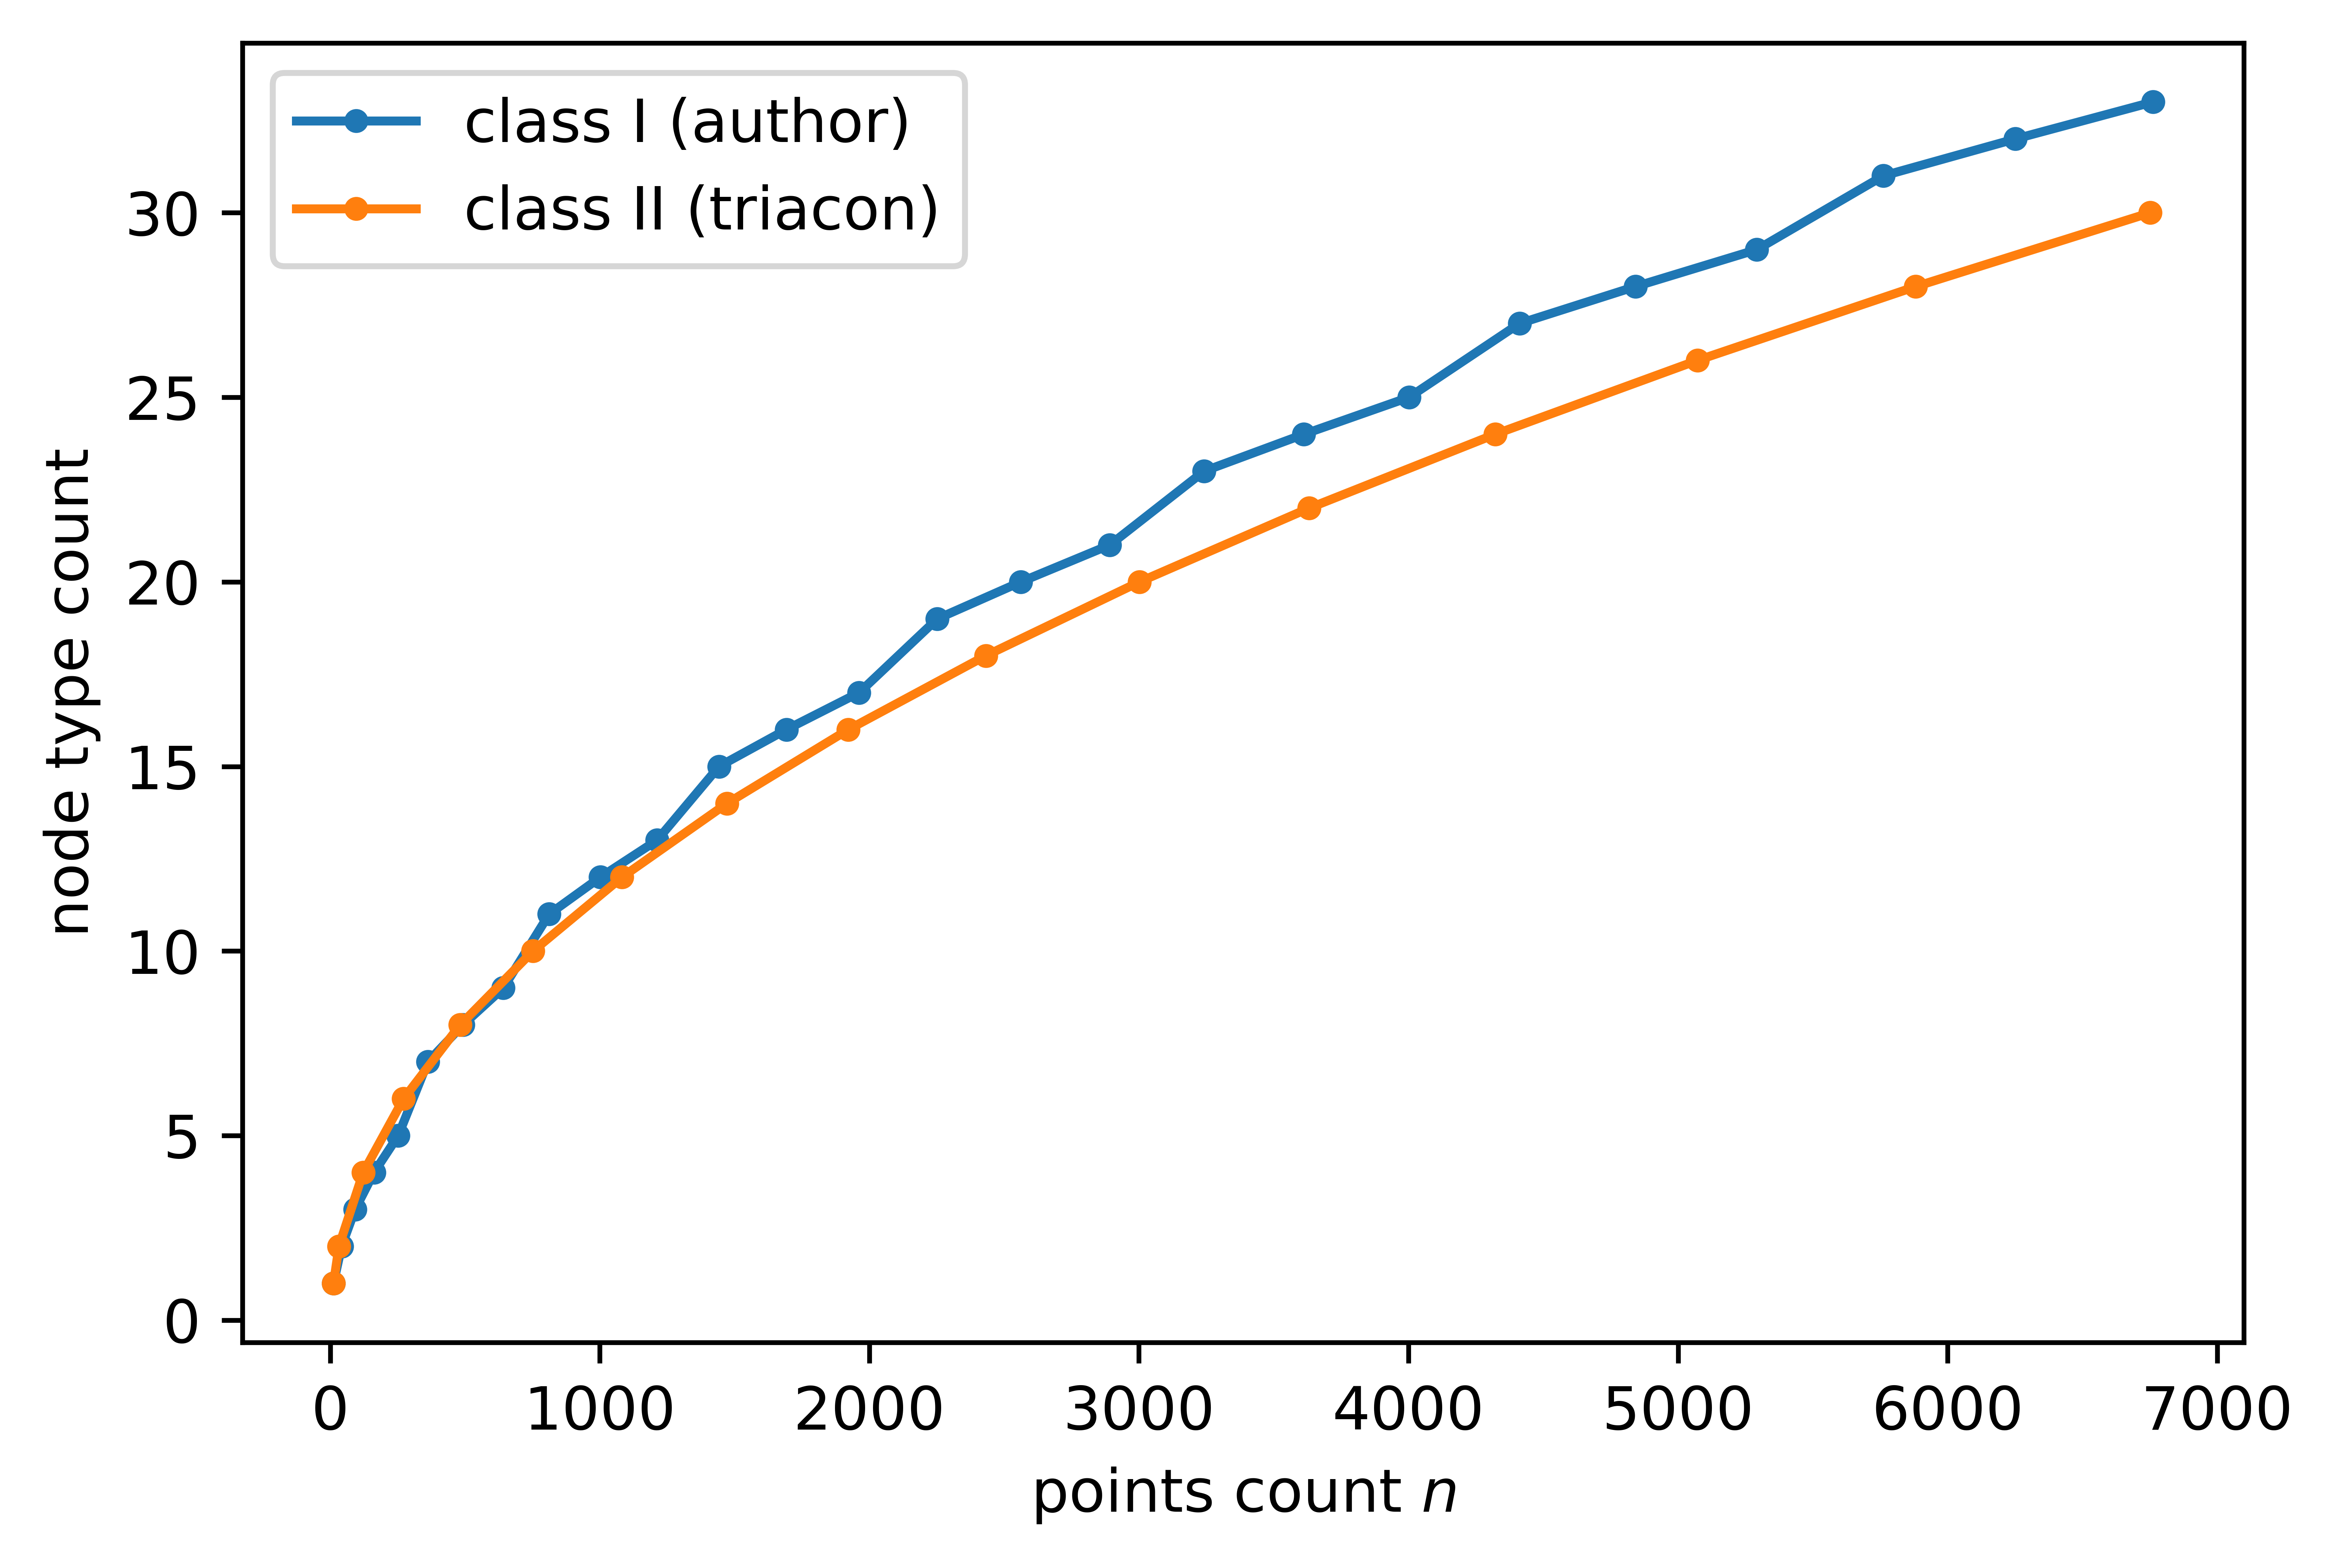

In [68]:
plt.figure(
  # figsize=(10,6),
  dpi=1200,
)
l1 = plt.plot(stats_ic1s[0], stats_ic1s[2], marker='.', label='class I (author)')
l2 = plt.plot(stats_ic2s[0], stats_ic2s[2], marker='.', label='class II (triacon)')

plt.xlabel("points count $n$")
plt.ylabel("node type count")
plt.legend()

plt.savefig("out/share/image/node_type_compare.jpg")

# plt.plot(stats_min_potential[0], stats_min_potential[2], marker='.')

# ns = list(set(stats_ic1s[0]).union(set(stats_ic2s[0])))
# ns = stats_ic2s[0]

# stats_min_potential_selected_x = []
# stats_min_potential_selected_y = []
# for i, n in enumerate(stats_min_potential[0]):
#   if n in ns and n in range(4,300):
#     stats_min_potential_selected_x.append(stats_min_potential[0][i])
#     stats_min_potential_selected_y.append(stats_min_potential[2][i])


# plt.plot(stats_min_potential_selected_x, stats_min_potential_selected_y, marker='.')

In [56]:
# plt.figure(
#   # figsize=(10,6),
#   dpi=1200,
# )

# ax1 = plt.subplot(2, 2, 1)
# ax1.plot(stats_ic1s[0], stats_ic1s[2], marker='.')
# ax1.plot(stats_ic2s[0], stats_ic2s[2], marker='.')

# ax1.xlabel("points count $n$")
# ax1.ylabel("joint type count")

# ax2 = plt.subplot(2, 2, 2, frameon=False)
# ax2.plot(stats_ic1s[0], stats_ic1s[3], marker='.')
# ax2.plot(stats_ic2s[0], stats_ic2s[3], marker='.')
# ax2.plot(stats_min_potential[0], stats_min_potential[3], marker='.')
# ax2.xlim(left=4)
# ax2.xlim(right=300)

# ax2.xlabel("points count $n$")
# ax2.ylabel("coefficient of variation of rod length")

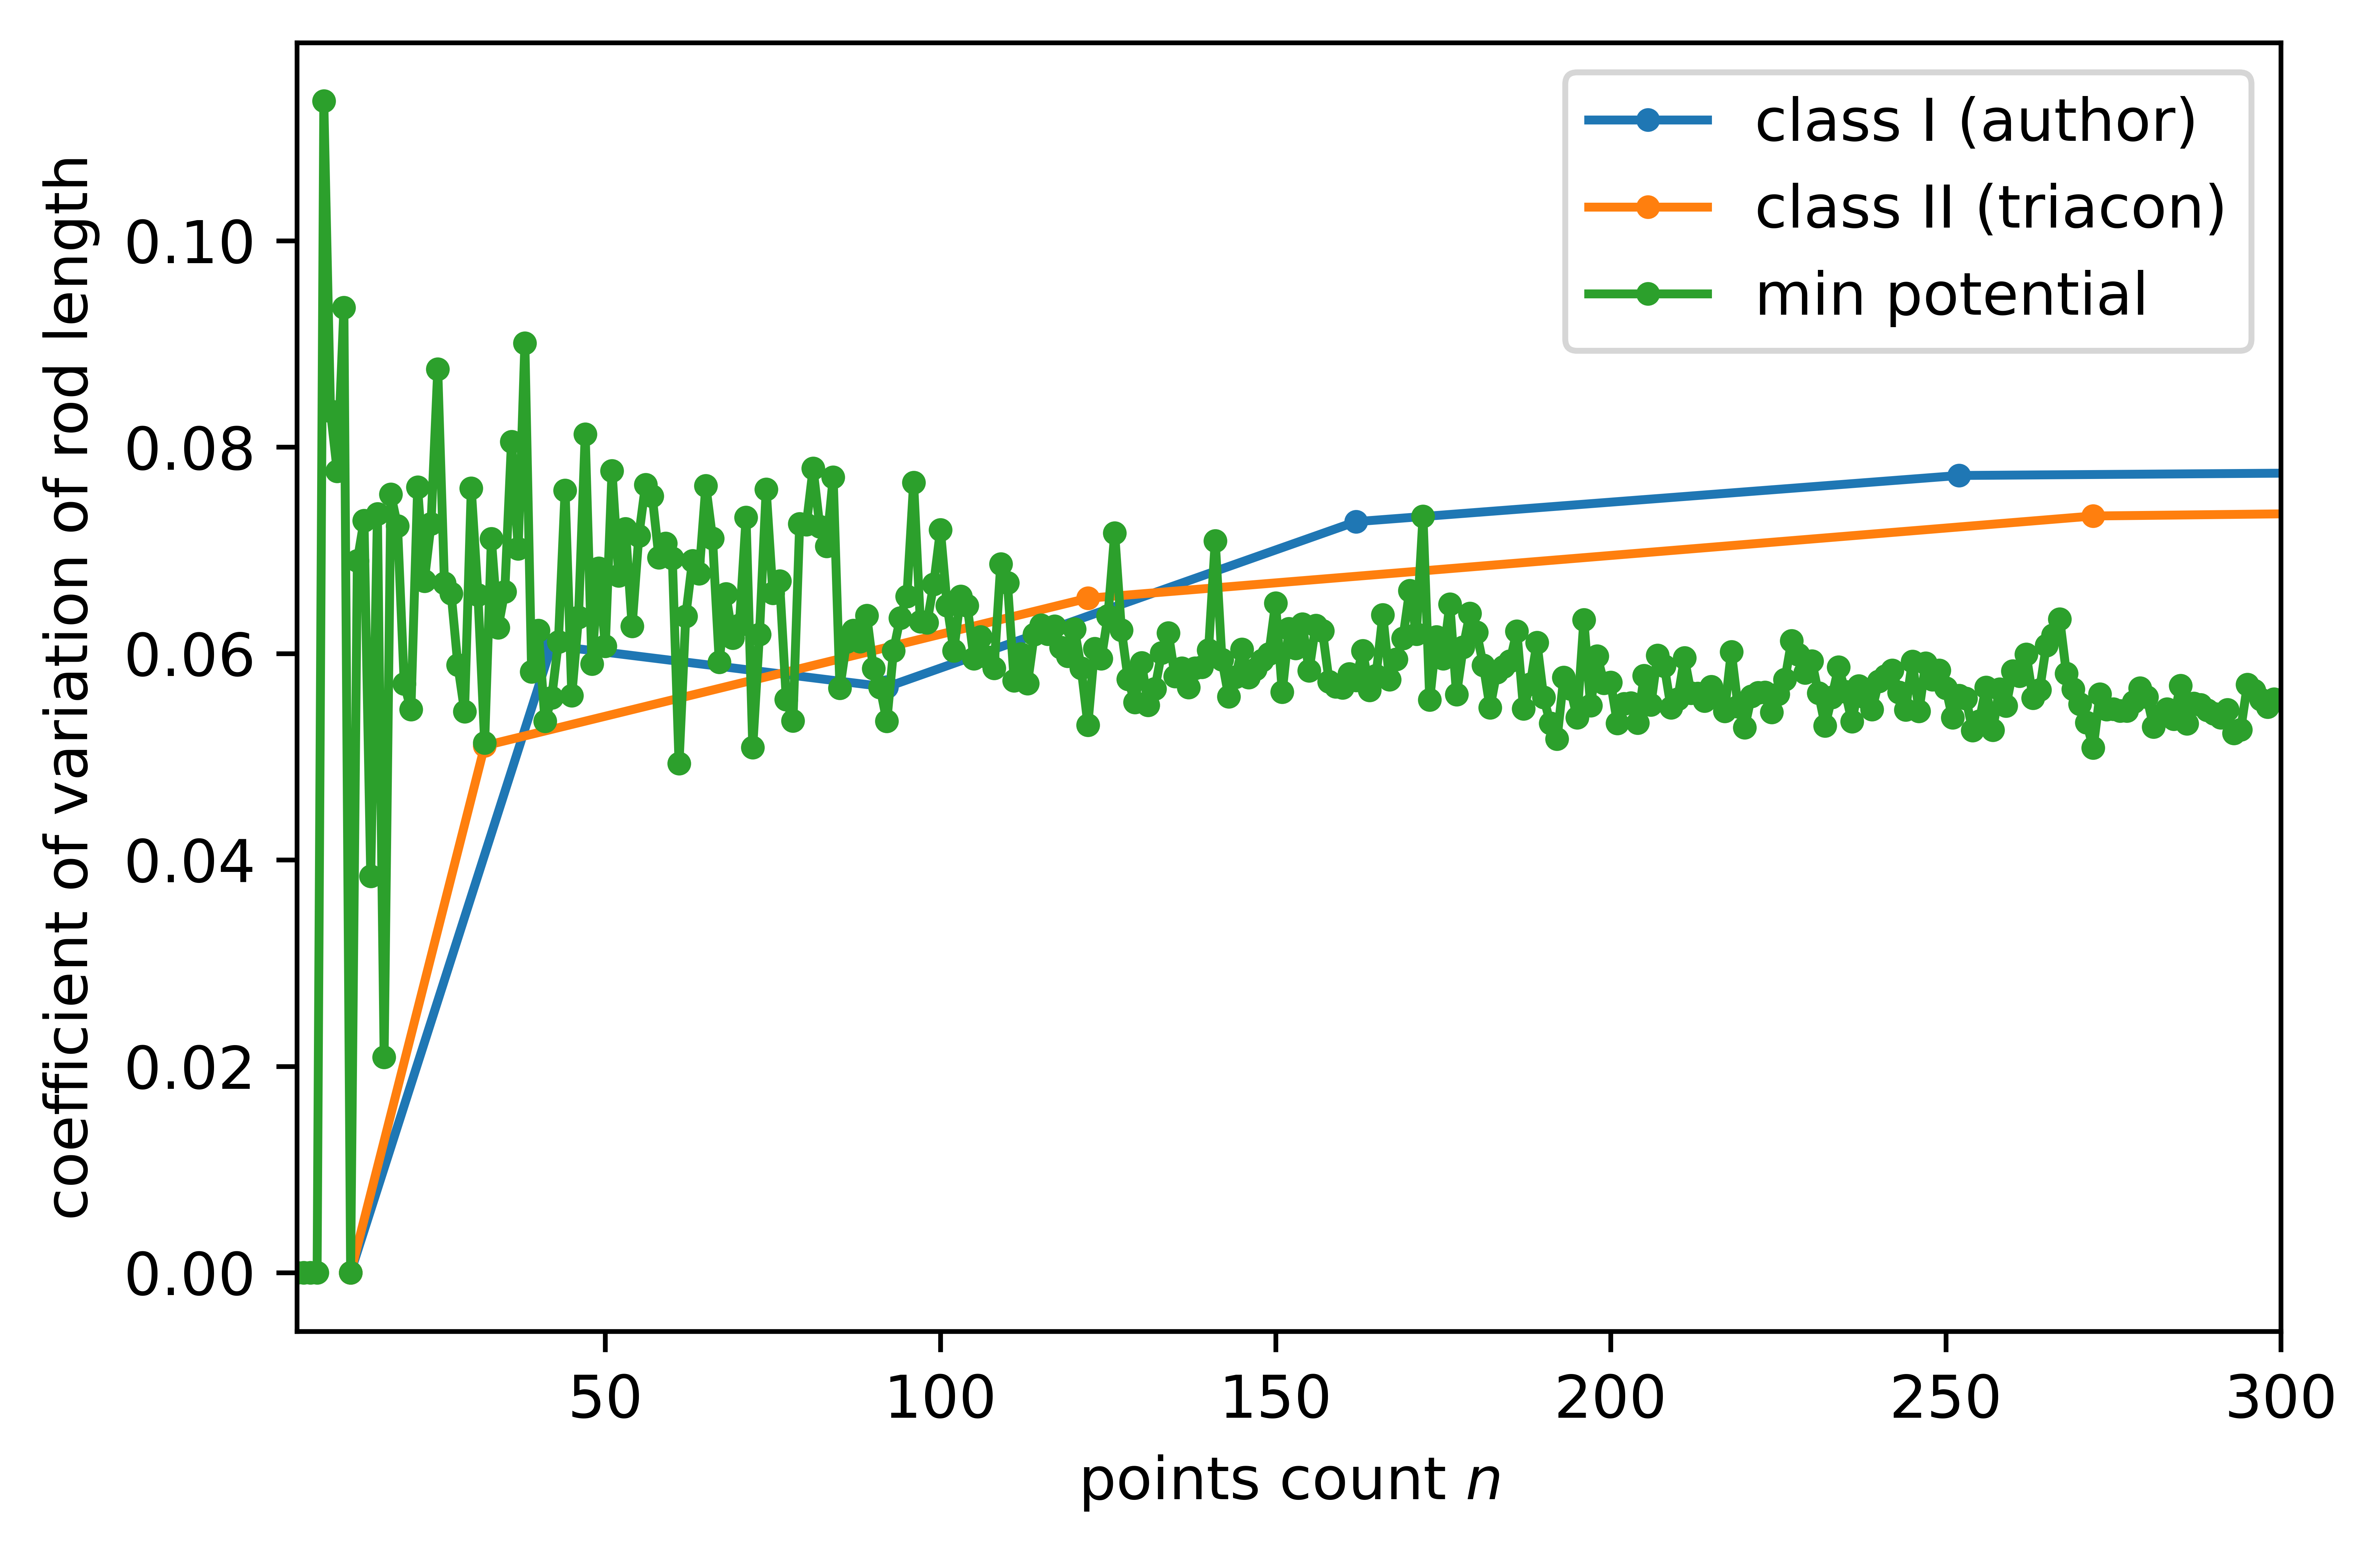

In [60]:
plt.figure(
  # figsize=(10,6),
  dpi=1200,
)

l1 = plt.plot(stats_ic1s[0], stats_ic1s[3], marker='.', label='class I (author)')
l2 = plt.plot(stats_ic2s[0], stats_ic2s[3], marker='.', label='class II (triacon)')
l3 = plt.plot(stats_min_potential[0], stats_min_potential[3], marker='.', label='min potential')
plt.xlim(left=4)
plt.xlim(right=300)

plt.xlabel("points count $n$")
plt.ylabel("coefficient of variation of edge length")
plt.legend()

plt.savefig("out/share/image/cv_compare.jpg")